In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import rubin_sim.maf as maf
from rubin_sim.maf.metrics.baseMetric import BaseMetric
import rubin_sim.maf.utils as mafUtils
import rubin_sim.utils as utils
from scipy import interpolate

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import rubin_sim.maf.db as db
import rubin_sim.maf.utils as utils
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.stackers as stackers
import rubin_sim.maf.metricBundles as metricBundles

from rubin_sim.utils import _galacticFromEquatorial
#from rubin_sim.photUtils import Dust_values

import scipy.integrate as integrate

In [3]:
# Grab this until datalab can update sims_photUtils
from rubin_sim.photUtils import Sed, BandpassDict
class Dust_values(object):
    """Calculate extinction values

    Parameters
    ----------
    R_v : float (3.1)
        Extinction law parameter (3.1).
    bandpassDict : dict (None)
        A dict with keys of filtername and values of rubin_sim.photUtils.Bandpass objects. Default
        of None will load the standard ugrizy bandpasses.
    ref_ev : float (1.)
        The reference E(B-V) value to use. Things in MAF assume 1.
    """
    def __init__(self, R_v=3.1, bandpassDict=None, ref_ebv=1.):
        # Calculate dust extinction values
        self.Ax1 = {}
        if bandpassDict is None:
            bandpassDict = BandpassDict.loadTotalBandpassesFromFiles(['u', 'g', 'r', 'i', 'z', 'y'])

        for filtername in bandpassDict:
            wavelen_min = bandpassDict[filtername].wavelen.min()
            wavelen_max = bandpassDict[filtername].wavelen.max()
            testsed = Sed()
            testsed.setFlatSED(wavelen_min=wavelen_min, wavelen_max=wavelen_max, wavelen_step=1.0)
            self.ref_ebv = ref_ebv
            # Calculate non-dust-extincted magnitude
            flatmag = testsed.calcMag(bandpassDict[filtername])
            # Add dust
            a, b = testsed.setupCCM_ab()
            testsed.addDust(a, b, ebv=self.ref_ebv, R_v=R_v)
            # Calculate difference due to dust when EBV=1.0 (m_dust = m_nodust - Ax, Ax > 0)
            self.Ax1[filtername] = testsed.calcMag(bandpassDict[filtername]) - flatmag

In [4]:
dust = Dust_values()
dust.Ax1

{'u': 4.809706374868417,
 'g': 3.6671737528219097,
 'r': 2.696160728857085,
 'i': 2.061624649177019,
 'z': 1.5859818809956767,
 'y': 1.3106840038717156}

In [5]:
dust.Ax1['r']/0.87

3.0990353205253847

In [6]:
class star_density(object):
    """integrate from zero to some max distance, then multiply by angular area
    
    Parameters
    ----------
    l : float
        Galactic longitude, radians
    b : float
        Galactic latitude, radians
    """
    def __init__(self, l,b):
        """Calculate the expected number of stars along a line of site"""
        self.r_thin = 2.6  # scale length of the thin disk, kpc
        self.D_gc = 8.178  # Distance to the galactic center, kpc
        self.h_thin = 0.300  # scale height of the thin disk, kpc
        
        self.l = l
        self.b = b
        
        self.A = 0.8e8/(4.*np.pi*self.h_thin*self.r_thin**2)
        
    def __call__(self, r):
        """
        Parameters
        ----------
        r : float
            Distance in kpc
        """
        R_galac = ((self.D_gc - r*np.cos(self.l))**2 + (r*np.sin(self.l))**2)**0.5
        
        exponent = -1.*r*np.abs(np.sin(self.b))/self.h_thin - R_galac/self.r_thin
        
        result = self.A * r**2 * np.exp(exponent)
        return result

In [7]:
sd = star_density(np.radians(0.),np.radians(90))
stars_per_sterr, _err = integrate.quad(sd, 0, 1.)
stars_per_sterr

5958.529508673472

In [8]:
import sys, os
fork_repo = '../rubinCadenceScratchWIC_fork/python/'
if os.path.isdir(fork_repo):
    # needed until changes are merged in Will Clarkson's repo
    sys.path.append(fork_repo) 
else:
    sys.path.append('../rubinCadenceScratchWIC/python/')

In [9]:
import readExtinction
readExtinction.__file__

'../rubinCadenceScratchWIC_fork/python/readExtinction.py'

In [10]:
class NYoungStarsMetric(BaseMetric):
    """Calculate the distance to which one could reach color uncertainties


    Parameters
    ----------
    metricName : str, opt
        Default 'young_stars'.
    m5Col : str, opt
        The default column name for m5 information in the input data. Default fiveSigmaDepth.
    filterCol : str, opt
        The column name for the filter information. Default filter.
    mags : dict
        The absolute magnitude of the object in question. Keys of filter name, values in mags.
        Default is for a 0.3 solar mass star at age = 100 Myr.
    snrs : dict
        The SNR to demand for each filter.
    galb_limit : float (25.)
        The galactic latitude above which to return zero (degrees). 
    badval : float, opt
        The value to return when the metric value cannot be calculated. Default 0.
    """
    def __init__(self, metricName='young_stars', m5Col='fiveSigmaDepth',
                 filterCol='filter',
                 badval=0, mags={'g': 10.32 , 'r': 9.28, 'i': 7.37}, galb_limit=5.,
                 snrs={'g': 5., 'r': 5., 'i': 5.},
                 **kwargs):
        Cols = [m5Col, filterCol]
        maps = ['DustMap']
        
        units = 'N stars'
        super(NYoungStarsMetric, self).__init__(Cols, metricName=metricName, units=units,
                                                badval=badval, maps=maps, *kwargs)
        # set return type
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.galb_limit = np.radians(galb_limit)
        
        self.mags = mags
        self.filters = list(self.mags.keys())
        self.snrs = snrs
        # Load up the dust properties
        dust_properties = Dust_values()
        self.Ax1 = dust_properties.Ax1
        # Load extinction map
        self.ebv=readExtinction.ebv3d()
        self.ebv.loadMap()
        
    def run(self, dataSlice, slicePoint=None):
        
        sky_area = hp.nside2pixarea(slicePoint['nside'], degrees=False)
        
        # if we are outside the galb_limit, return nothing
        # Note we could make this a more comlicated function that returns an expected density of 
        # star forming regions
        if np.abs(slicePoint['galb']) > self.galb_limit:
            return self.badval
        
        l,b = slicePoint['gall'],slicePoint['galb']
        pix = slicePoint['sid']
        #print(pix)
        
        # Coadd depths for each filter
        depths = {}
        for filtername in self.filters:
            in_filt = np.where(dataSlice[self.filterCol] == filtername)[0]
            depths[filtername] = 1.25 * np.log10(np.sum(10.**(.8*dataSlice[self.m5Col])))
           
        # solve for the distances in each filter where we hit the required SNR
        distances = []
        for filtername in self.filters:
            #print(filtername)
            # Apparent magnitude at the SNR requirement
            m_app = -2.5*np.log10(self.snrs[filtername]/5.)
            m_app += depths[filtername]
            #A_x = self.Ax1[filtername] * slicePoint['ebv']
            # Assuming all the dust along the line of sight matters. 
            #m_app = m_app - A_x
            
            #d = 10.*(100**((m_app - self.mags[filtername])/5.))**0.5
            d,dm,far = self.ebv.getDistanceAtMag(deltamag=m_app-self.mags[filtername],sfilt=filtername,ipix=pix)
            distances.append(d[0])
        # compute the final distance, limited by whichever filter is most shallow
        final_distance = np.min(distances,axis=-1)/1e3  # to kpc
        #print(final_distance)        
        
        # Resorting to numerical integration of ugly function
        sd = star_density(slicePoint['gall'], slicePoint['galb'])
        stars_per_sterr, _err = integrate.quad(sd, 0, final_distance)
        stars_tot = stars_per_sterr * sky_area
        
        return stars_tot

class VolumeSumMetric(BaseMetric):
    """Compute the total volume assuming a metric has values of distance
    """
    def __init__(self, col=None, metricName='VolumeSum', nside=None, **kwargs):
        super(VolumeSumMetric, self).__init__(col=col, metricName=metricName, **kwargs)
        self.pix_area = hp.nside2pixarea(nside)
        
    def run(self, dataSlice, slicePoint=None):
        # volume of sphere, times ratio of pixel area divided by area of sphere
        vols = 1./3. * dataSlice[self.colname]**3 * self.pix_area
        return np.sum(vols)

In [11]:
dbFile = '/sims_maf/fbs_2.0/baseline/baseline_v2.0_10yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [12]:
nside = 64
bundleList = []
sql = ''
# Let's plug in the magnitudes for one type
metric = NYoungStarsMetric()
slicer = slicers.HealpixSlicer(nside=nside, useCache=False)
# By default, the slicer uses RA and Dec. Let's add in galactic coords so it knows 
# XXX--should integrate this more with MAF I suppose. 
gall, galb = _galacticFromEquatorial(slicer.slicePoints['ra'],slicer.slicePoints['dec'])
slicer.slicePoints['gall'] = gall
slicer.slicePoints['galb'] = galb

summaryStats = [metrics.SumMetric()]
plotDict = {'logScale':True, 'colorMin': 1}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                             runName=runName))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [13]:
slicer.slicePoints['sid']

array([    0,     1,     2, ..., 49149, 49150, 49151])

Querying database observations with no constraint for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'rotSkyPos', 'filter'].
Found 2086980 visits
Running:  ['_sims_maf_fbs_2_0_baseline_baseline_v2_0_10yrs_young_stars_HEAL']


/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/maps/dustMap.py:25: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(f"Slicer value of nside {slicePoints['nside']} different "
0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 287 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.


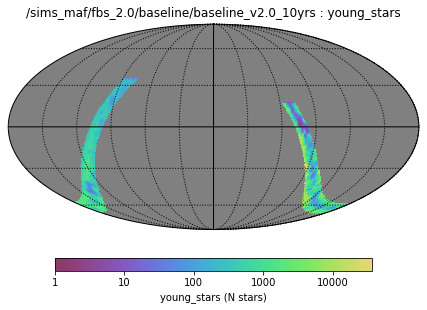

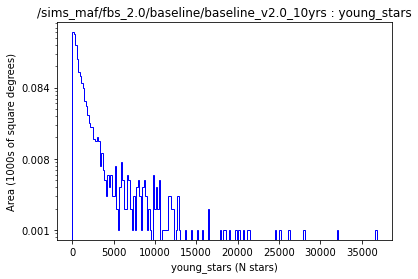

In [14]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [15]:
for bl in bundleList:
    print(runName, bl.metric.name, bl.summaryValues)

/sims_maf/fbs_2.0/baseline/baseline_v2.0_10yrs young_stars {'Sum': 3481901.477256053}


In [16]:
dbFile = '/sims_maf/fbs_1.5/footprints/footprint_gp_smoothv1.5_10yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [17]:
nside = 64
bundleList = []
sql = ''
# Let's plug in the magnitudes for one type
metric = NYoungStarsMetric()
slicer = slicers.HealpixSlicer(nside=nside, useCache=False)
# By default, the slicer uses RA and Dec. Let's add in galactic coords so it knows 
# XXX--should integrate this more with MAF I suppose. 
gall, galb = _galacticFromEquatorial(slicer.slicePoints['ra'],slicer.slicePoints['dec'])
slicer.slicePoints['gall'] = gall
slicer.slicePoints['galb'] = galb

summaryStats = [metrics.SumMetric()]
plotDict = {'logScale':True, 'colorMin': 1}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                             runName=runName))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'rotSkyPos', 'filter'].
Found 2223753 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_gp_smoothv1_5_10yrs_young_stars_HEAL']


/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/maps/dustMap.py:25: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(f"Slicer value of nside {slicePoints['nside']} different "
0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


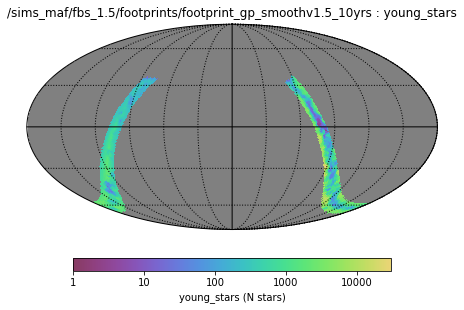

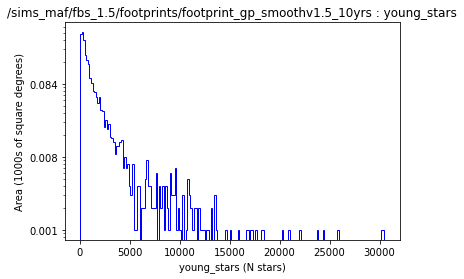

In [18]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [19]:
for bl in bundleList:
    print(runName, bl.metric.name, bl.summaryValues)

/sims_maf/fbs_1.5/footprints/footprint_gp_smoothv1.5_10yrs young_stars {'Sum': 4166189.6002647476}


In [20]:
dbFile = '/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [21]:
nside = 64
bundleList = []
sql = ''
# Let's plug in the magnitudes for one type
metric = NYoungStarsMetric()
slicer = slicers.HealpixSlicer(nside=nside, useCache=False)
# By default, the slicer uses RA and Dec. Let's add in galactic coords so it knows 
# XXX--should integrate this more with MAF I suppose. 
gall, galb = _galacticFromEquatorial(slicer.slicePoints['ra'],slicer.slicePoints['dec'])
slicer.slicePoints['gall'] = gall
slicer.slicePoints['galb'] = galb

summaryStats = [metrics.SumMetric()]
plotDict = {'logScale':True, 'colorMin': 1}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                             runName=runName))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [22]:
slicer.slicePoints['sid']

array([    0,     1,     2, ..., 49149, 49150, 49151])

Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec', 'rotSkyPos', 'filter'].
Found 2045493 visits
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp2_v1_7_10yrs_young_stars_HEAL']


/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/maps/dustMap.py:25: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(f"Slicer value of nside {slicePoints['nside']} different "
0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


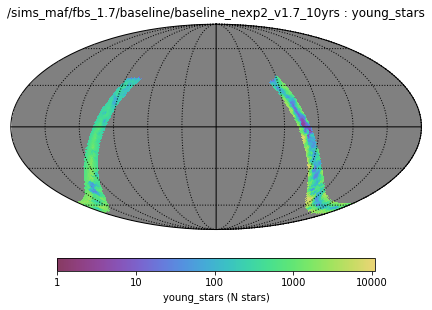

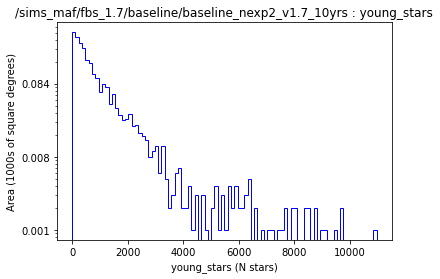

In [23]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [24]:
for bl in bundleList:
    print(runName, bl.metric.name, bl.summaryValues)

/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs young_stars {'Sum': 2608809.9445177857}
